In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_frame = pd.read_csv("./data/mnist_train.csv", sep=",", header=None)

In [11]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
data_frame.loc[:, 1:] /= 255.0

In [18]:
tmp = data_frame.loc[1, :]

In [19]:
tmp[tmp != 0]

128    0.200000
129    0.623529
130    0.992157
131    0.623529
132    0.196078
155    0.188235
156    0.933333
157    0.988235
158    0.988235
159    0.988235
160    0.929412
182    0.211765
183    0.890196
184    0.992157
185    0.988235
186    0.937255
187    0.913725
188    0.988235
189    0.223529
190    0.023529
208    0.039216
209    0.235294
210    0.878431
211    0.988235
212    0.992157
213    0.988235
214    0.792157
215    0.329412
216    0.988235
217    0.992157
         ...   
577    0.874510
578    0.654902
579    0.219608
595    0.333333
596    0.988235
597    0.988235
598    0.988235
599    0.898039
600    0.843137
601    0.988235
602    0.988235
603    0.988235
604    0.768627
605    0.509804
623    0.109804
624    0.780392
625    0.988235
626    0.988235
627    0.992157
628    0.988235
629    0.988235
630    0.913725
631    0.568627
652    0.098039
653    0.501961
654    0.988235
655    0.992157
656    0.988235
657    0.552941
658    0.145098
Name: 1, Length: 176, dt

In [21]:
data=data_frame.as_matrix()

In [22]:
image=data[0,1:].reshape((28,28))

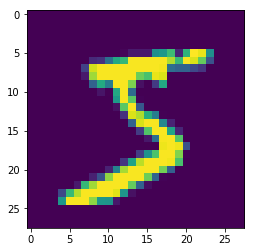

In [23]:
plt.imshow(image)
plt.show()

In [24]:
def show_image(data_matrix, index):
	image=data_matrix[index,1:].reshape((28,28))
	plt.imshow(image)
	plt.show()

In [25]:
data.shape

(60000, 785)

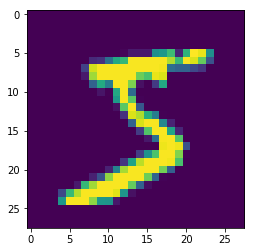

In [26]:
show_image(data, 0)

In [446]:
class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, activation_functions = None):
        self.number_of_classes = 10
        self.train_data = train_data
        train_data_without_labels = train_data[:,1:]
        self.input_neurons_num = train_data_without_labels.shape[0] \
            if len(train_data_without_labels.shape) == 1 \
            else train_data_without_labels.shape[1]
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: self.sigmoid_function(x)] * (self.layers_num - 2) + \
            [lambda x: self.softmax_function(x)] 
        self.weight_list = [np.random.randn(current_layer_num, next_layer_num) \
                       for (current_layer_num, next_layer_num) in \
                            zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        
        self.bias_list = [np.random.randn(1, layer_num) for layer_num in self.neurons_num_per_layer[1:]]
        
    def main(self, batch_size):
        train_batches = self.create_train_batches(batch_size)
        probabilities = feed_forward(map(lambda x: x[:,1:], train_batches))
        labels = map(lambda x: np.transpose(self.one_hot_encoded(x[:, 0:1].reshape(9))), train_batches)
        self.back_propagation(probabilities, labels)
        # TODO: finish
        
  
    def feed_forward(self, train_batches):
        probabilities = []
        for train_batch in train_batches:
            layer_output = train_batch
            labels = self.one_hot_encoded(train_batch[:, 0])
            for activation_function, w, b in zip(self.activation_functions, self.weight_list, self.bias_list):
                layer_output = activation_function(np.matmul(layer_output, w) + b)
            probabilities.append(layer_output)
        return probabilities
    
    def back_propagation(self, probabilities, labels):
        diff=np.zeros(len(probabilities))
        for batch_probabilities, batch_labels in zip(probabilities, labels):
            diff[i]=batch_probabilities-batch_labels
            delta[i]=diff[i]* 
        
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        train_labels = train_labels.astype(int)
        res = np.zeros((self.number_of_classes, train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        

In [447]:
net = Network(data[1:10], [2,3])

In [448]:
[matrix.shape for matrix in net.weight_list]

[(784, 2), (2, 3), (3, 10)]

In [449]:
net.input_neurons_num

784

In [450]:
net.weight_list

[array([[-0.70266254, -0.16810186],
        [-0.19271632, -0.33625673],
        [-0.51784442, -1.4567981 ],
        ...,
        [ 0.48825724,  0.28333801],
        [ 0.11838629, -0.83411458],
        [ 0.07268617,  0.51261866]]),
 array([[ 1.02684963, -0.1840947 , -0.07048534],
        [ 0.81033149, -0.56197621, -1.57622453]]),
 array([[-1.30900913,  1.79747724,  0.76755576,  0.255539  , -1.64962265,
         -0.24123068, -0.89939784,  0.95577892, -1.07584875,  0.09477656],
        [ 0.00579611, -1.17855804, -1.18522406, -0.55014297, -1.66295321,
         -0.59817376, -0.39760599,  0.61956292, -2.933876  , -1.23779308],
        [ 0.64835329, -0.14396898, -0.80641468, -0.57725782,  0.87432533,
         -0.81983659, -0.79285689,  0.87871844,  1.89406859,  0.89937512]])]

In [451]:
net.sigmoid_function(0)

0.5

In [452]:
[matrix.shape for matrix in net.create_train_batches(2)]

[(2, 785), (2, 785), (2, 785), (2, 785), (1, 785)]

In [453]:
np.argmax(net.softmax_function(np.array([1,2,3])))

2

In [454]:
net.softmax_function(np.array([1,2,3]))

array([0.09003057, 0.24472847, 0.66524096])

In [455]:
net.one_hot_encoded(np.array([1,2,3,4]))

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [456]:
net.feed_forward(2)

array([[0.09418001, 0.06953579, 0.03617574, 0.04824329, 0.00385223,
        0.02182844, 0.07931603, 0.06331932, 0.00520984, 0.01875052],
       [0.04519423, 0.1769889 , 0.07670037, 0.07034788, 0.0019266 ,
        0.02859459, 0.0770754 , 0.06260437, 0.00281009, 0.01734636],
       [0.07371107, 0.12506433, 0.05078415, 0.05798142, 0.00294249,
        0.02329438, 0.07123817, 0.0849492 , 0.00475393, 0.0217767 ],
       [0.10126438, 0.07790695, 0.04042501, 0.05339538, 0.00414814,
        0.02411478, 0.08700538, 0.06916109, 0.00561061, 0.02047244],
       [0.04967759, 0.15815471, 0.06755927, 0.06542033, 0.00208064,
        0.02653186, 0.07380602, 0.06569748, 0.00310288, 0.01783987],
       [0.06709631, 0.11383366, 0.04622468, 0.05277642, 0.00267844,
        0.02120344, 0.0648446 , 0.07732267, 0.00432726, 0.01982186],
       [0.07176517, 0.1205853 , 0.04910629, 0.0561684 , 0.00286547,
        0.0225971 , 0.06924486, 0.08219211, 0.00461978, 0.02110395],
       [0.07198242, 0.12004569, 0.0489952

In [457]:
net.neurons_num_per_layer

[784, 2, 3, 10]

In [458]:
len(net.create_train_batches(2))

5

In [459]:
net.back_propagation(net.feed_forward(2))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [460]:
net.train_data[:, 0:1]

array([[0.],
       [4.],
       [1.],
       [9.],
       [2.],
       [1.],
       [3.],
       [1.],
       [4.]])